In [1]:
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode = False, precision = 4)

In [2]:
# Hyperparameters
class HParams:
    def __init__(self):
        
        # Problem params
        self.num_agents = 2
        self.num_states = 2
        self.num_signals = 2
        
        self.theta = np.array([0.50, 0.50])
        self.alpha = 0.5
        
        # Minibatch size
        self.batch_size = 128
        self.num_misreports = 100
        
        
        # Number of layer
        self.R = 3
        # Number of hidden units
        self.K = 200
        
        # Data - Choose among exp, uniform, assymetric_uniform, irregular
        self.distr_type = "exp"
        
        # Opt params
        self.lr = 1e-3
        
        self.gd_lr = 5e-3
        self.gd_iter = 0
        
        self.temp = 0.1
        
        # Lagrangian params
        self.lag_ic_init = 10
        self.lag_up_iter = 100
        
        self.pho_init = 1
        self.pho_increment = 10
        self.pho_up_iter = 1000
        
        # Miscellaneous
        self.seed = 0
                  
        self.max_iter = 10000 
        self.print_iter = 1000
        
        
        """ Test params """
        self.test_batch_size = 1024
        self.test_num_misreports = 100
        self.test_num_batches = 200
        self.test_gd_lr =  5e-3
        self.test_gd_iter = 100
        
                
# Initialize config
cfg = HParams()
np.random.seed(cfg.seed)

# Asserts
assert(cfg.num_agents == 2)
device = "cuda"

np.random.seed(cfg.seed)

In [3]:
def sample_batch(batch_size):
    return np.random.dirichlet([1,1], (batch_size, cfg.num_agents))

In [4]:
# Utils
def torch_var(x): return torch.Tensor(x).to(device)
def numpy_var(x): return x.detach().cpu().numpy()

In [5]:
# TODO: Initializations, Softmax temperatures

class ActionNet(nn.Module):      
    def __init__(self, cfg):
        super(ActionNet, self).__init__()
        self.cfg = cfg
        
        num_agents = self.cfg.num_agents
        num_states = self.cfg.num_states
        num_signals = self.cfg.num_signals
        
        num_layers = self.cfg.R
        num_hidden_nodes = self.cfg.K
        
        self.theta = torch_var(self.cfg.theta)[:, None]
        self.temp = torch_var([self.cfg.temp])

        self.pi = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_agents * num_states, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pi.append(m)
        self.pi.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pi.append(m)
            self.pi.append(nn.LeakyReLU())
         
        # Output-1
        m = nn.Linear(num_hidden_nodes, num_agents * num_states * num_signals)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.experiment = m
        
        # Output-2
        m = nn.Linear(num_hidden_nodes, num_agents)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.winner = m
        
        # Pay-Net
        self.pay = nn.ModuleList()
        
        # Input layer
        m = nn.Linear(num_agents * num_states, num_hidden_nodes)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
        nn.init.constant_(m.bias, 0)
        self.pay.append(m)
        self.pay.append(nn.LeakyReLU())
        
        # Hidden layers
        for i in range(num_layers - 1):
            m = nn.Linear(num_hidden_nodes, num_hidden_nodes)
            nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('leaky_relu'))
            nn.init.constant_(m.bias, 0)
            self.pay.append(m)
            self.pay.append(nn.LeakyReLU())

         
        # Output layer
        m = nn.Linear(num_hidden_nodes, num_agents)
        nn.init.xavier_uniform_(m.weight.data, gain = nn.init.calculate_gain('sigmoid'))
        nn.init.constant_(m.bias, 0)
        self.pay.append(m)
        self.pay.append(nn.Sigmoid())
        
        

    def forward(self, theta):

        out = theta.view(-1, cfg.num_agents * cfg.num_states)
        for module in self.pi: out = module(out)
        
        # out-1
        pi = self.experiment(out).view(-1, self.cfg.num_agents, self.cfg.num_states, self.cfg.num_signals)
        pi =  F.softmax(pi / self.temp, dim = -1)
        
        winner = self.winner(out)
        w = F.softmax(winner, dim = -1)
        
        out = theta.view(-1, cfg.num_agents * cfg.num_states)
        for module in self.pay: out = module(out)
        
        pay_frac = out
        x = torch.max(pi * theta[..., None], axis = -2)[0].sum(axis = -1)
        u_in = w * x
        u_out = torch.max(theta, axis = -1)[0] * w
        
        pay = pay_frac * (u_in - u_out)

        return w, pi, pay

In [6]:
def compute_x(theta, pi):
    """
    Theta: [Batch, Num_agents, Num_states]
    Pi: [Batch, Num_agents, Num_states, Num_signals]
    """
    
    x = torch.max(pi * theta[..., None], axis = -2)[0].sum(axis = -1)
    return x

In [7]:
def compute_ic_viol_samples(b, theta, u):
    
    ic_viol = torch.zeros(cfg.num_agents).to(device)
    
    batch_size, num_misreports = b.shape[0], b.shape[1]
    theta_mis = theta[:, None, :, :].repeat(1, num_misreports, 1, 1)
        
    # Compute IC violation for each agent
    for i in range(cfg.num_agents):  
        
        # Compose misreport of shape: [batch_size, num_misreports, num_agents, num_states]
        b_mis = torch.cat((theta_mis[:, :, :i, :], b[:, :, i: i + 1, :], theta_mis[:, :, i + 1:, :]), axis = -2)
        b_mis = b_mis.view(-1, cfg.num_agents, cfg.num_states)
        
        # Compute action_mis, pay_mis
        w_mis, pi_mis, pay_mis = action_net(b_mis)
        
        # Utility of misreporting:
        x_mis = compute_x(theta_mis.view(-1, cfg.num_agents, cfg.num_states), pi_mis)
        u_mis = w_mis[:, i] * x_mis[:, i] - pay_mis[:, i]
        u_mis = u_mis.view(-1, num_misreports)
        
        u_true = u[:, i]
        ic_viol[i] += F.relu(u_mis.max(-1)[0] - u[:, i]).mean()
            
    return ic_viol

In [8]:
action_net = ActionNet(cfg).to(device)

In [9]:
lag_ic_init = cfg.lag_ic_init
w_ic = torch.ones(cfg.num_agents).to(device) * lag_ic_init

pho = cfg.pho_init
pho_increment = cfg.pho_increment

opt = torch.optim.AdamW(list(action_net.parameters()), lr=cfg.lr)

it = 1

In [10]:
import time
tic = time.time()
                                  
while it <= cfg.max_iter:
    
    opt.zero_grad()
    
    # Get batch - (Theta: B X NA X NS)
    THETA = sample_batch(cfg.batch_size)
    theta = torch_var(THETA)
    
    # w, pay - (B X NA), pi - (B X NA X NS X NSi)
    w, pi, pay = action_net(theta)
    
    # Compute Revenue
    revenue = pay.sum(axis = -1).mean()
    
    # Compute Utility
    # x - (B X NA), u - (B X NA)
    x = compute_x(theta, pi)
    u = w * x - pay
    
    # Compute IC-Violation
    # b - (B X NM X NA X NS)
    b = torch_var(sample_batch(cfg.batch_size * cfg.num_misreports).reshape(cfg.batch_size, cfg.num_misreports, cfg.num_agents, cfg.num_states))
    ic_viol = compute_ic_viol_samples(b, theta, u)
     
    # Compute Loss
    rev_loss = -revenue
    lagrangian = torch.dot(w_ic, ic_viol)
    penalty = pho * (ic_viol**2).sum()
    loss = rev_loss + penalty + lagrangian
    
    # GD Step
    loss.backward()   
    opt.step()
    
    if it % cfg.print_iter == 0:
        print("[Iter: %d], [Time Elapsed: %.2fs]"%(it, time.time() - tic))
        print("[Rev: %.4f], [IC Viol: %.4f]"%(revenue.sum(), ic_viol.mean().item()))
        
    if it % cfg.lag_up_iter == 0:
        w_ic.data += pho * ic_viol.data
        
    if it % cfg.pho_up_iter == 0:
        pho += pho_increment
        
    it += 1

[Iter: 1000], [Time Elapsed: 10.82s]
[Rev: 0.2371], [IC Viol: 0.0004]
[Iter: 2000], [Time Elapsed: 21.34s]
[Rev: 0.2480], [IC Viol: 0.0008]
[Iter: 3000], [Time Elapsed: 31.87s]
[Rev: 0.2498], [IC Viol: 0.0005]
[Iter: 4000], [Time Elapsed: 42.39s]
[Rev: 0.2532], [IC Viol: 0.0005]
[Iter: 5000], [Time Elapsed: 52.90s]
[Rev: 0.2567], [IC Viol: 0.0006]
[Iter: 6000], [Time Elapsed: 63.32s]
[Rev: 0.2474], [IC Viol: 0.0006]
[Iter: 7000], [Time Elapsed: 73.75s]
[Rev: 0.2402], [IC Viol: 0.0002]
[Iter: 8000], [Time Elapsed: 84.16s]
[Rev: 0.2430], [IC Viol: 0.0004]
[Iter: 9000], [Time Elapsed: 94.60s]
[Rev: 0.2448], [IC Viol: 0.0004]


KeyboardInterrupt: 

In [11]:
D = 201
t = torch_var(np.linspace(0, 1, D))
t_mesh = torch.stack(torch.meshgrid(t, t, indexing = "ij"), axis = -1)[..., None]
t_mesh = torch.tile(t_mesh, (1, 1, 1, 2))
t_mesh[..., 1] = 1 - t_mesh[..., 1]

In [12]:
w, pi, _ = action_net(t_mesh.view(-1, cfg.num_agents, cfg.num_states))
x = compute_x(t_mesh.view(-1, cfg.num_agents, cfg.num_states), pi)
x = x.view(D, D, 2)
w = w.view(D, D, 2)

In [16]:
AM = numpy_var(x)

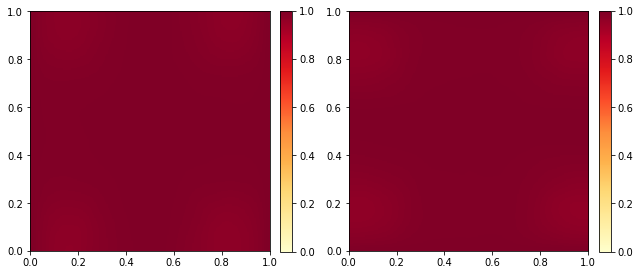

In [17]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(9,4))

img_1 = ax[0].imshow(AM[:, :, 0].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_1, ax = ax[0], fraction=0.046, pad=0.04)

img_2 = ax[1].imshow(AM[:, :, 1].transpose(1,0), extent=[0,1,0,1], vmin = 0.0, vmax=1.0, cmap = 'YlOrRd', origin = "lower")
plt.colorbar(img_2, ax = ax[1], fraction=0.046, pad=0.04)

fig.tight_layout()

In [15]:
w

tensor([[[0.5069, 0.4931],
         [0.5055, 0.4945],
         [0.5040, 0.4960],
         ...,
         [0.5040, 0.4960],
         [0.5054, 0.4946],
         [0.5068, 0.4932]],

        [[0.5086, 0.4914],
         [0.5070, 0.4930],
         [0.5055, 0.4945],
         ...,
         [0.5055, 0.4945],
         [0.5069, 0.4931],
         [0.5083, 0.4917]],

        [[0.5102, 0.4898],
         [0.5087, 0.4913],
         [0.5071, 0.4929],
         ...,
         [0.5070, 0.4930],
         [0.5085, 0.4915],
         [0.5099, 0.4901]],

        ...,

        [[0.5090, 0.4910],
         [0.5076, 0.4924],
         [0.5063, 0.4937],
         ...,
         [0.5072, 0.4928],
         [0.5087, 0.4913],
         [0.5102, 0.4898]],

        [[0.5074, 0.4926],
         [0.5061, 0.4939],
         [0.5048, 0.4952],
         ...,
         [0.5056, 0.4944],
         [0.5071, 0.4929],
         [0.5085, 0.4915]],

        [[0.5059, 0.4941],
         [0.5046, 0.4954],
         [0.5033, 0.4967],
         ...,
 

In [ ]:
w